In [1]:
from fastai.vision.all import *
from fastai.vision.data import *
from fastai.vision.core import *
from fastai2_extensions.interpret.all import *
# from fastai.imports import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
path = Path('../resources/feb2021_abclass')

In [4]:
# vis_path = Path('visualizations_02-02-2021/round2')
# os.path.exists(vis_path)

In [5]:
import warnings

In [6]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [7]:
data = ImageDataLoaders.from_folder(path, train='train', valid='val', 
                                  batch_tfms=[*aug_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.0, max_warp=0, p_affine=0),Normalize.from_stats(*imagenet_stats)],
                                  bs=32, 
                                  resize_method=ResizeMethod.Squish,
                                  size=(512, 512), num_workers=8) 

TypeError: 'NoneType' object is not iterable

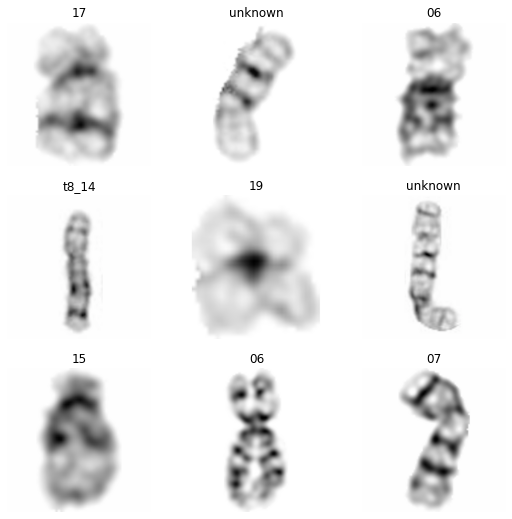

In [6]:
data.show_batch()

In [8]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [9]:
from fastai.metrics import error_rate, BalancedAccuracy, F1Score, RocAuc
f1_score = F1Score(average='weighted')
acc = BalancedAccuracy()

<h1><center style='background:orange'>vgg19 exp1</center></h1>

In [9]:
learn = cnn_learner(data, models.vgg19_bn, metrics=[error_rate, acc, f1_score])

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [11]:
learn.recorder.summary()

Sequential (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 512 x 512 
Conv2d                                    1792       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36928      False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 256 x 25 
Conv2d                                    73856      False     
BatchNorm2d                               256        True      
ReLU                                                           
Conv2d                                    147584     False     
BatchNorm2d                               

In [12]:
defaults.device = torch.device('cuda')

In [13]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,2.697369,1.991330,0.644295,0.399430,0.347208,04:17
1,1.764621,1.539947,0.506711,0.515242,0.488986,04:06
2,1.413360,1.428149,0.479866,0.547009,0.507715,04:06


SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=6.309573450380412e-07)

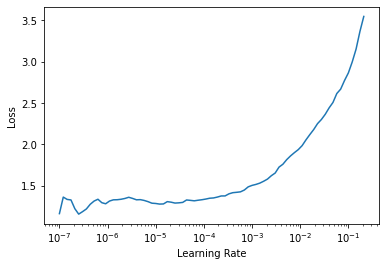

In [14]:
learn.unfreeze()
learn.lr_find()

In [15]:
learn.fit_one_cycle(5, slice(8e-5, 8e-4))

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,1.484493,1.987580,0.624161,0.382051,0.336283,06:45
1,0.834975,0.781867,0.261745,0.737892,0.732349,06:46
2,0.465833,0.476958,0.147651,0.840741,0.850362,06:46
3,0.249279,0.293190,0.097315,0.883048,0.902626,06:46
4,0.132980,0.232088,0.083893,0.908689,0.917199,06:46


In [16]:
learn.save('vgg16_exp1_bs32_is512_shortcycle_stage1.h5')

Path('feb2021_abclass/models/vgg16_exp1_bs32_is512_shortcycle_stage1.h5.pth')

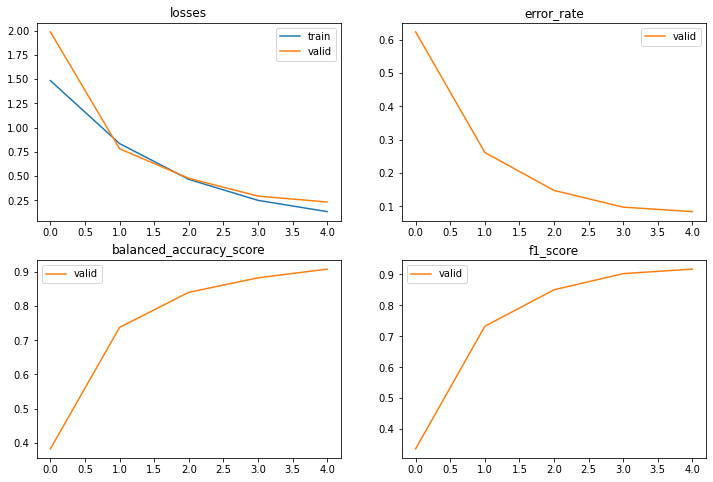

In [18]:
learn.recorder.plot_metrics()

<h1><center style='background:orange'>vgg19 exp2</center></h1>

In [9]:
learn = cnn_learner(data, models.vgg19_bn, metrics=[error_rate, acc, f1_score])

In [10]:
defaults.device = torch.device('cuda')

In [11]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,2.677012,1.921609,0.604027,0.443590,0.365302,04:37
1,1.772906,1.520276,0.510067,0.505840,0.477061,04:29
2,1.402447,1.376029,0.459732,0.569801,0.528953,04:29


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=5.754399353463668e-06)

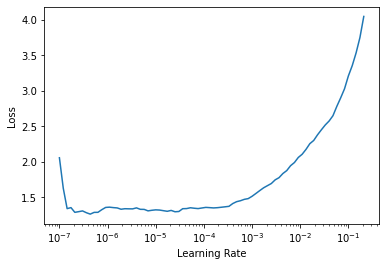

In [12]:
learn.unfreeze()
learn.lr_find()

In [13]:
learn.fit_one_cycle(5, slice(8e-5, 8e-4))

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,1.499499,1.591295,0.466443,0.568519,0.523354,05:57
1,0.871024,0.640416,0.194631,0.785613,0.800296,06:46
2,0.507481,0.412121,0.140940,0.830484,0.853064,06:46
3,0.234029,0.288174,0.090604,0.903561,0.909191,06:46
4,0.134592,0.266254,0.093960,0.891168,0.906571,06:46


# Crap 

In [14]:
learn.save('vgg16_exp2_bs32_is512_shortcycle_stage1.h5')

Path('feb2021_abclass/models/vgg16_exp2_bs32_is512_shortcycle_stage1.h5.pth')

<h1><center style='background:orange'>vgg19 exp3</center></h1>

In [10]:
learn = cnn_learner(data, models.vgg19_bn, metrics=[error_rate, acc, f1_score])

In [11]:
defaults.device = torch.device('cuda')

In [12]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,2.692209,1.959648,0.590604,0.453846,0.380243,04:39
1,1.723092,1.461532,0.456376,0.554558,0.525213,04:29
2,1.406871,1.354433,0.426174,0.570513,0.566881,04:28


SuggestedLRs(lr_min=9.999999747378752e-07, lr_steep=2.2908675418875646e-06)

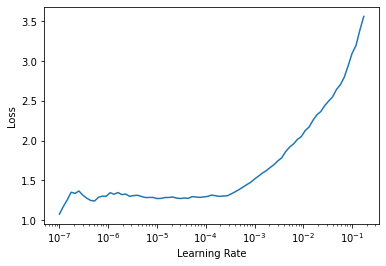

In [13]:
learn.unfreeze()
learn.lr_find()

In [14]:
learn.fit_one_cycle(5, slice(8e-5, 8e-4))

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,1.432908,1.746566,0.513423,0.502707,0.457588,05:55
1,0.905484,0.581120,0.174497,0.800712,0.819534,06:45
2,0.489819,0.451363,0.151007,0.826638,0.845622,06:44
3,0.226462,0.272680,0.073826,0.916382,0.925355,06:44
4,0.137730,0.225186,0.073826,0.908689,0.926270,06:44


In [15]:
learn.save('vgg19_exp3_bs32_is512_shortcycle_stage1.h5')

Path('feb2021_abclass/models/vgg19_exp3_bs32_is512_shortcycle_stage1.h5.pth')